In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import h5py
import pqcd

from pathlib import Path
from pqcd.utils import (
    to_GeV_per_cubic_femtometre, 
    to_nucleons_per_cubic_femtometre, 
)

In [2]:
rng = np.random.default_rng(0)

In [3]:
def parse_process_group(group):
    """helper function to read stuff out of our hdf5 data structures
    return weight, x_tst, f_tst, cov_f_f, (xlabel, flabel), (poly_degree, sigma, length_scale, sigma_obs)
    """
    attrs = group.attrs
    weight = attrs['weight']

    xlabel = attrs['xlabel']
    if not isinstance(xlabel, str): ### check for compatibility issues between Python 2 and 3...
        xlabel = xlabel.astype(str)

    flabel = attrs['flabel']
    if not isinstance(flabel, str):
        flabel = flabel.astype(str)

    poly_degree = attrs['poly_degree']
    sigma = attrs['sigma']
    length_scale = attrs['length_scale']
    sigma_obs = attrs['sigma_obs']
    m = attrs['model_multiplier'] if ('model_multiplier' in attrs.keys()) else None

    x_tst = group['mean'][xlabel]
    f_tst = group['mean'][flabel]

    cov_f_f = group['cov'][...]

    return weight, x_tst, f_tst, cov_f_f, (xlabel, flabel), (poly_degree, sigma, length_scale, sigma_obs, m)

In [4]:
labels = [
    'cusaagn',
    'cusbagn',
    'cuscagn',
    'cusdagn',
    'cuseagn',
    'cusfagn',
    'cusgagn',
    'cushagn',
    'cusiagn',
    'cusjagn'
]

In [5]:
set_number = 18
set_path = Path(f'../data/eos-draws-modified/{set_number:02}')

mean_dict = {}
cov_dict = {}
hyperparam_dict = {}

for label in labels:

    mean_dict[label] = {}
    cov_dict[label] = {}
    hyperparam_dict[label] = {}
    
    file_path = set_path / label / f'gpr_gpr_{label}.hdf5'

    with h5py.File(file_path, 'r') as obj:
        for key in obj.keys():
            weight, x, f, cov, (xlabel, flabel), (p, s, l, S, m) = parse_process_group(obj[key])
            cov_dict[label][int(key)] = cov
            mean_dict[label][int(key)] = (x,f)
            hyperparam_dict[label][int(key)] = {
                'poly_degree':p,
                'sigma':s,
                'length_scale':l,
                'sigma_obs':S,
                'model_multiplier':m,
                }

In [6]:
plot = False

if plot:

    for label in mean_dict.keys():

        fig, axs = plt.subplots(2, 1, sharex=True, figsize=(6,8))
        fig.suptitle(label)
        axs[0].set_xscale('log')

        for model_number in range(10):

            log_pressure, phi = mean_dict[label][model_number]

            hyperparams = hyperparam_dict[label][model_number]
            degree = hyperparams['poly_degree']
            sigma = hyperparams['sigma']
            l = hyperparams['length_scale']
            sigma_obs = hyperparams['sigma_obs']
            
            axs[0].plot(
                to_GeV_per_cubic_femtometre(np.exp(log_pressure)), 
                phi, 
                label=f'$d = {degree},\ \sigma = {sigma:.2},\ \ell = {l:.2},\ \sigma_\mathrm{{obs}} = {sigma_obs:.2}$'
            )
            axs[1].plot(
                to_GeV_per_cubic_femtometre(np.exp(log_pressure)), 
                1/(1+np.exp(phi)), 
            )

        axs[0].legend(loc='upper right', bbox_to_anchor=(1.75,1))

        axs[1].set_xlabel(r'Pressure, $p$ [GeV/fm$^3$]')
        axs[0].set_ylabel(r'$\phi$')
        axs[1].set_ylabel(r'$c_s^2$');

So we have our means and corresponding hyperparameters. I want to create a new kernel (square exponential) for each using the relevant hyperparameters. Then, instead of conditioning (which changes the mean), I am instead going to apply a scaling to the kernel so that we follow the desired behaviour at low and high pressures.

In [7]:
def kSE(x, xp, sigma, ell):
    return sigma**2*np.exp(-(x-xp)**2/(2*ell**2))

In [81]:
def scaling(x, x_ref, n_scale, sigma_scale=0):
    return sigma_scale + (1-sigma_scale)/(1+(x_ref/x)**n_scale)

In [9]:
# All x=logp arrays are the same
x_star = mean_dict['cusaagn'][0][0]

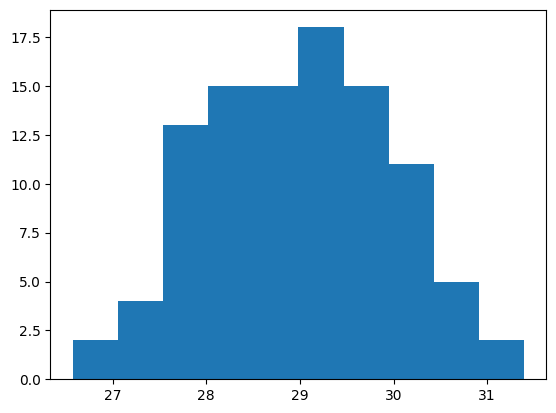

In [16]:
x_ref_low_sample = rng.normal(loc=29, scale=1, size=100)

fig, ax = plt.subplots()
ax.hist(x_ref_low_sample);

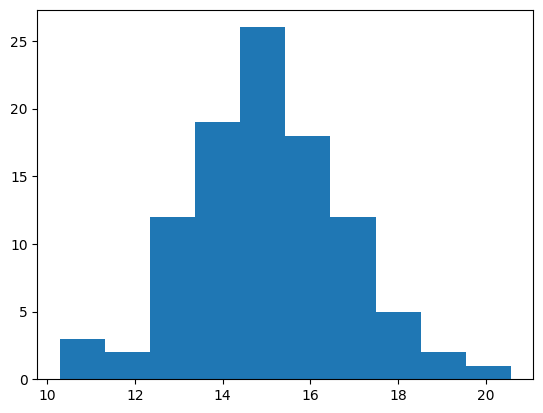

In [18]:
n_scale_low_sample = rng.normal(loc=15, scale=2.5, size=100)

fig, ax = plt.subplots()
ax.hist(n_scale_low_sample);

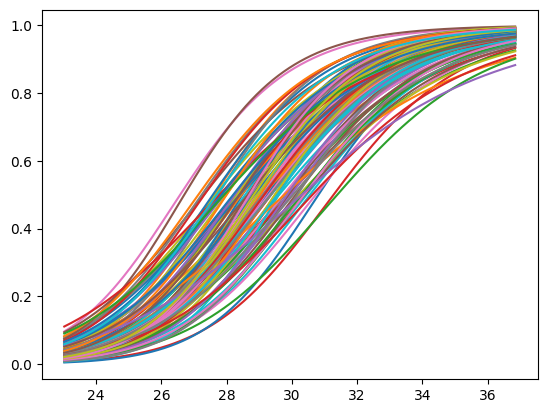

In [82]:
fig, ax = plt.subplots()

for x_ref, n_scale in zip(x_ref_low_sample, n_scale_low_sample):
    ax.plot(x_star, scaling(x_star, x_ref=x_ref, n_scale=n_scale))

In [21]:
def stitch(x, x_ref, n_stitch, sigma_stitch):
    return sigma_stitch**2*np.exp(n_stitch*(x-x_ref))

In [22]:
x_stitch = np.linspace(np.log(1e14), np.log(1e16), num=100)

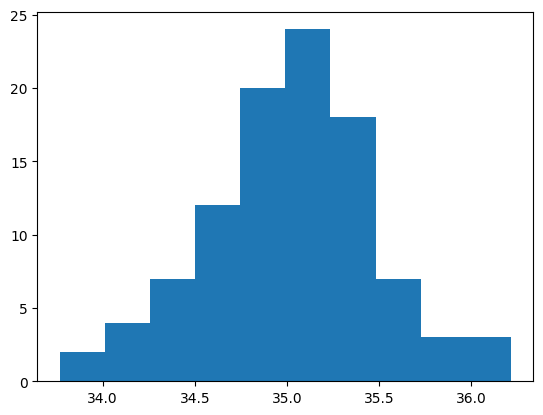

In [97]:
x_ref_high_sample = rng.normal(loc=35, scale=0.5, size=100)

fig, ax = plt.subplots()
ax.hist(x_ref_high_sample);

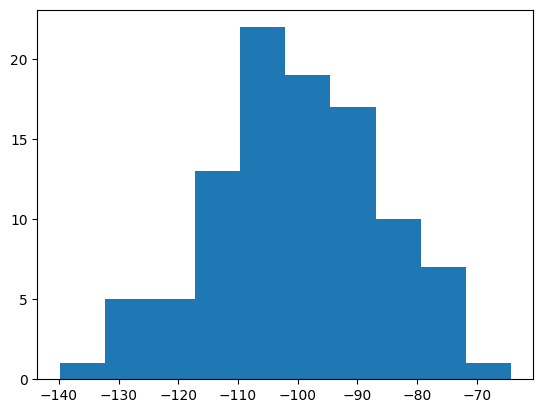

In [44]:
n_scale_high_sample = rng.normal(loc=-100, scale=15, size=100)

fig, ax = plt.subplots()
ax.hist(n_scale_high_sample);

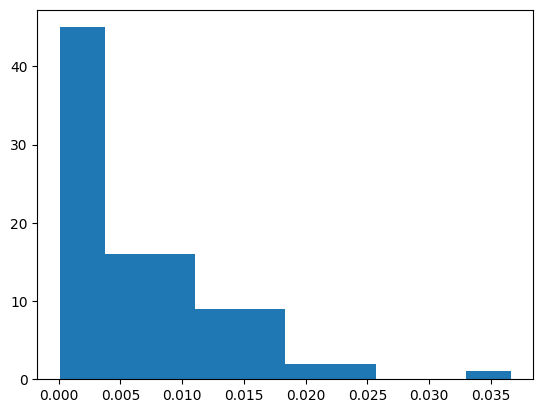

In [86]:
sigma_scale_high_sample = abs(rng.normal(loc=0., scale=0.01, size=100))

fig, ax = plt.subplots()
ax.hist(sigma_scale_high_sample);

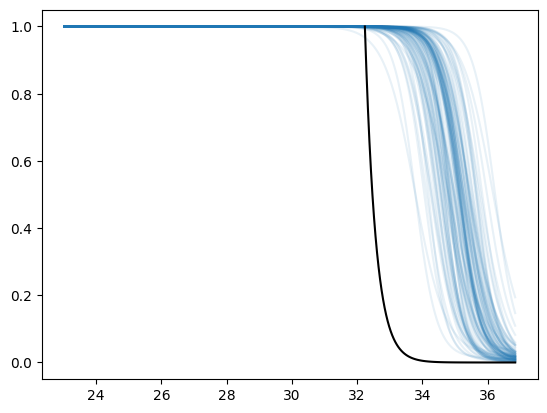

In [98]:
fig, ax = plt.subplots()
ax.plot(x_stitch, stitch(x_stitch, x_ref=np.log(1e16), n_stitch=-3, sigma_stitch=0.1)/max(stitch(x_stitch, x_ref=np.log(1e16), n_stitch=-3, sigma_stitch=0.1)), zorder=10, c='k')

for x_ref, n_scale, sigma_scale in zip(x_ref_high_sample, n_scale_high_sample, sigma_scale_high_sample):
    ax.plot(x_star, scaling(x_star, x_ref=x_ref, n_scale=n_scale, sigma_scale=sigma_scale), c='C0', alpha=0.1)

In [99]:
custom_cov_dict = {}

for label_count, label in enumerate(labels):

    means = mean_dict[label]
    hyperparams = hyperparam_dict[label]

    custom_cov_dict[label] = {}

    for model_count in range(10):

        mean = means[model_count]

        sigma = hyperparams[model_count]['sigma']
        ell = hyperparams[model_count]['length_scale']

        index = 10*label_count + model_count
        x_ref_low = x_ref_low_sample[index]
        n_scale_low = n_scale_low_sample[index]
        x_ref_high = x_ref_high_sample[index]
        n_scale_high = n_scale_high_sample[index]
        sigma_scale_high = sigma_scale_high_sample[index]

        custom_cov = np.zeros((len(x_star), len(x_star)))
        for i, x in enumerate(x_star):
            for j, xp in enumerate(x_star):
                custom_cov[i,j] = kSE(x, xp, sigma=sigma, ell=ell)

        low_scaling_matrix = np.zeros((len(x_star), len(x_star)))
        for i, xi in enumerate(x_star):
            for j, xj in enumerate(x_star):
                low_scaling_matrix[i,j] = \
                    scaling(xi, x_ref=x_ref_low, n_scale=n_scale_low)*scaling(xj, x_ref=x_ref_low, n_scale=n_scale_low)
                
        high_scaling_matrix = np.zeros((len(x_star), len(x_star)))
        for i, xi in enumerate(x_star):
            for j, xj in enumerate(x_star):
                high_scaling_matrix[i,j] = \
                    scaling(
                        xi, 
                        x_ref=x_ref_high, 
                        n_scale=n_scale_high, 
                        sigma_scale=sigma_scale_high
                    ) * \
                    scaling(
                        xj, 
                        x_ref=x_ref_high, 
                        n_scale=n_scale_high, 
                        sigma_scale=sigma_scale_high
                    )
                
        custom_cov *= low_scaling_matrix*high_scaling_matrix

        custom_cov_dict[label][model_count] = custom_cov

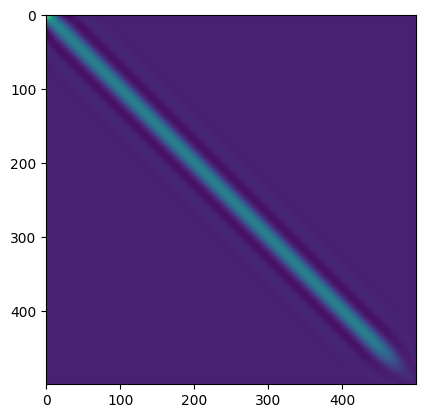

In [90]:
plt.imshow(cov_dict['cusaagn'][0]);

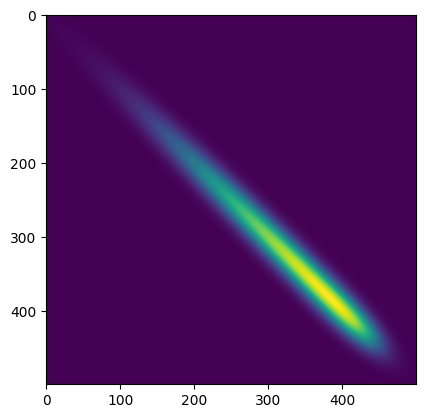

In [100]:
plt.imshow(custom_cov_dict['cusaagn'][0]);

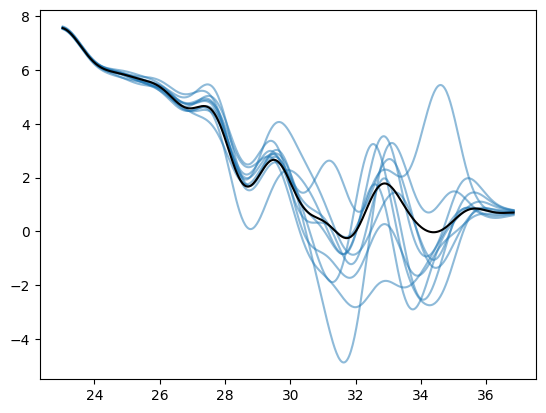

In [102]:
fig, ax = plt.subplots()

label = labels[5]
model_number = 2

ax.plot(*mean_dict[label][model_number], c='k', zorder=5)

repeats = 10
for _ in range(repeats):
    ax.plot(
        x_star, 
        rng.multivariate_normal(mean_dict[label][model_number][1], custom_cov_dict[label][model_number]), 
        alpha=0.5, 
        c='C0'
        )

In [103]:
source_set = Path(f'../data/eos-draws-modified/17')

dest_set = Path(f'../data/eos-draws-modified/22')
dest_set.mkdir(parents=True, exist_ok=True)

for label in labels:

    source_file = source_set / label / f'gpr_gpr_{label}.hdf5'

    dest_dir = dest_set / label
    dest_dir.mkdir(parents=True, exist_ok=True)

    dest_file = dest_dir / f'gpr_gpr_{label}.hdf5'

    with h5py.File(source_file, 'r') as f_src:
        with h5py.File(dest_file, 'w') as f_dest:
            
            for n, (log_pressure, phi) in mean_dict[label].items():

                new_mean = np.empty(
                    len(log_pressure), 
                    dtype=[('log(pressurec2)', 'float'), ('phi', 'float')]
                    )
                new_mean['log(pressurec2)'][:] = log_pressure
                new_mean['phi'][:] = phi

                # Modify by the scaling matrix
                new_cov = custom_cov_dict[label][n]

                # Copy all the groups and datasets
                f_src.copy(str(n), f_dest)

                # Delete the original dataset
                del f_dest[str(n)]['mean']
                del f_dest[str(n)]['cov']

                # Create a new dataset
                f_dest[str(n)].create_dataset('mean', data=new_mean)
                f_dest[str(n)].create_dataset('cov', data=new_cov)

In [104]:
set_number = 22
set_path = Path(f'../data/eos-draws-modified/{set_number:02}')

new_mean_dict_verify = {}
new_cov_dict_verify = {}
for label in labels:
    new_mean_dict_verify[label] = {}
    new_cov_dict_verify[label] = {}
    file_path = set_path / label / f'gpr_gpr_{label}.hdf5'
    with h5py.File(file_path, 'r') as f:
        for model_number in range(10):
            cov = np.array(f[str(model_number)]['cov'])
            mean = np.array(f[str(model_number)]['mean'])
            log_pressure = np.array([entry[0] for entry in mean])
            phi = np.array([entry[1] for entry in mean])
            new_cov_dict_verify[label][model_number] = cov
            new_mean_dict_verify[label][model_number] = (log_pressure,phi)

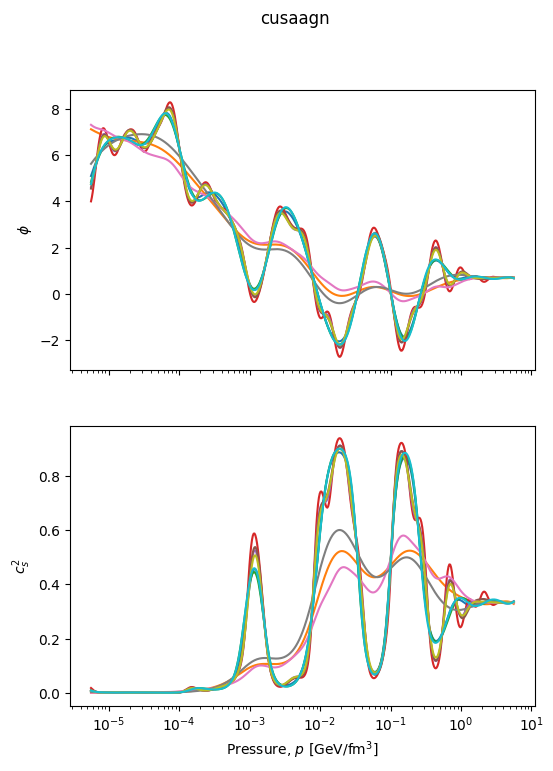

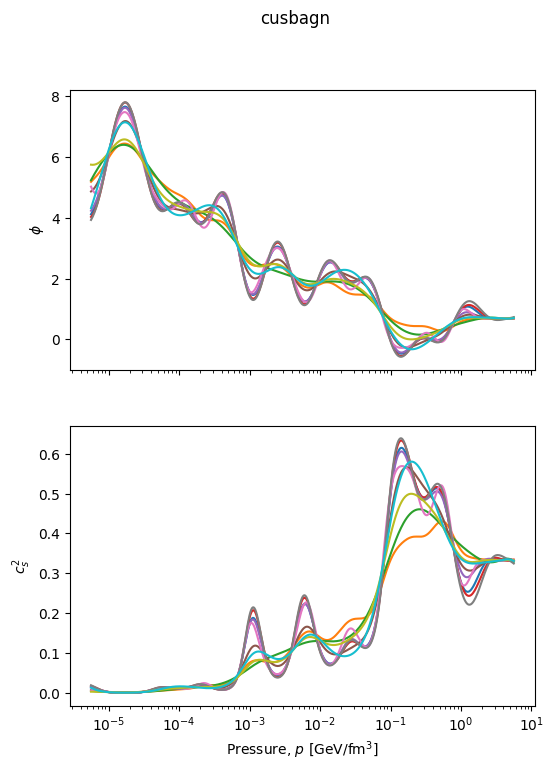

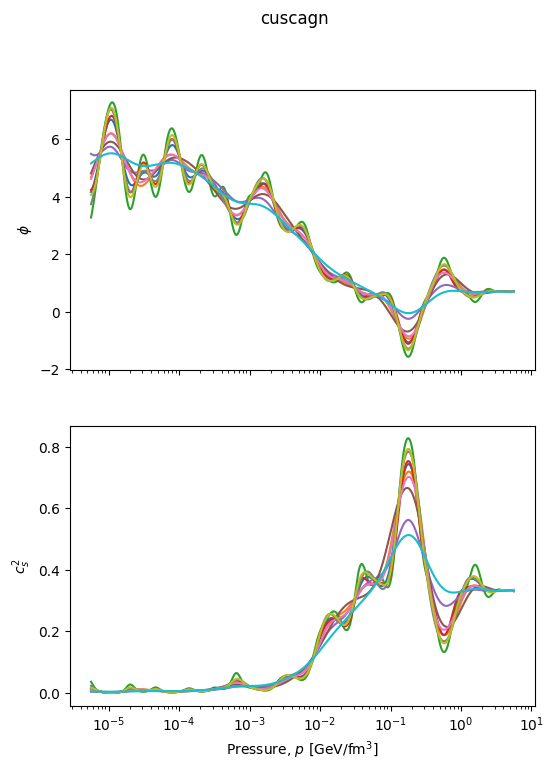

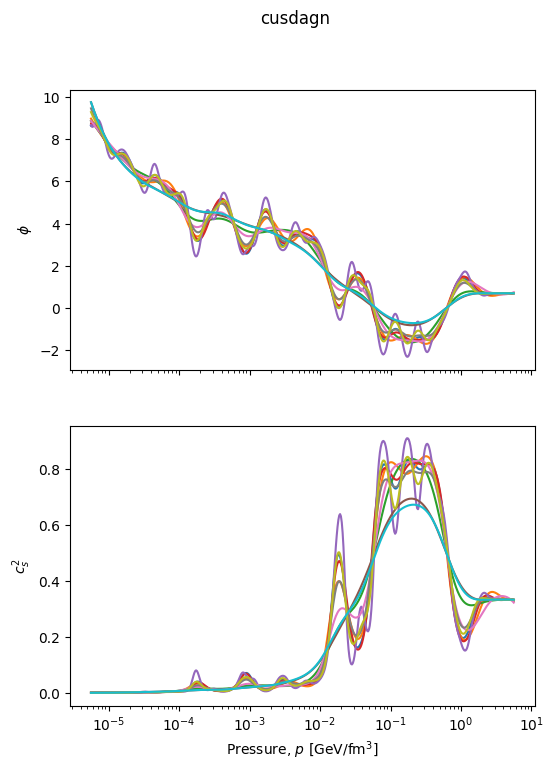

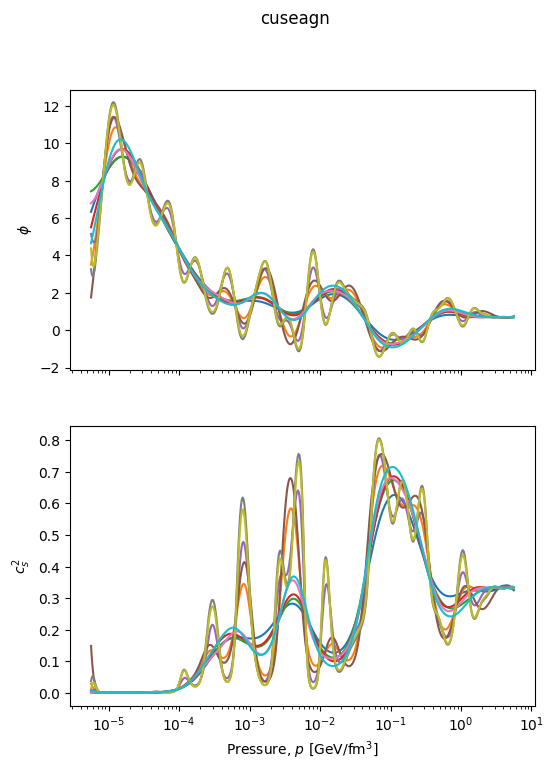

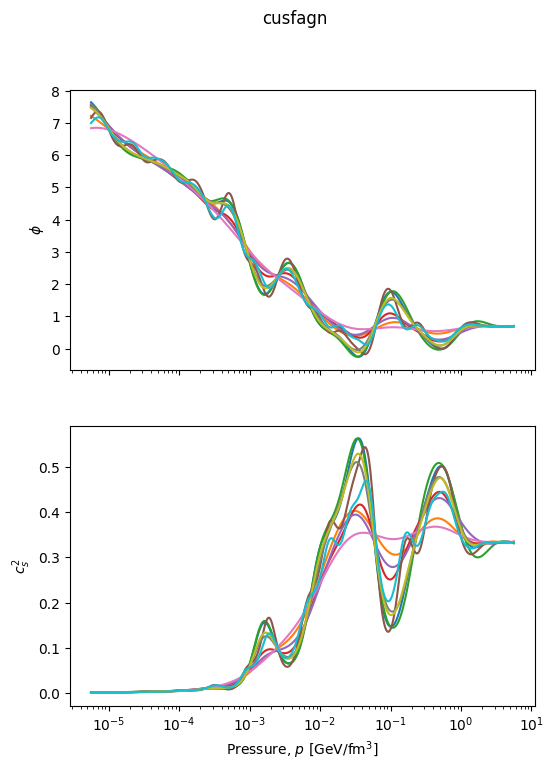

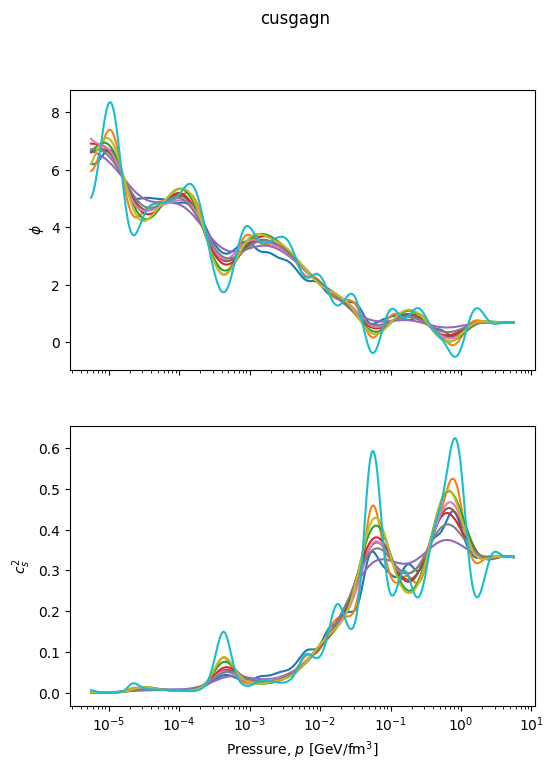

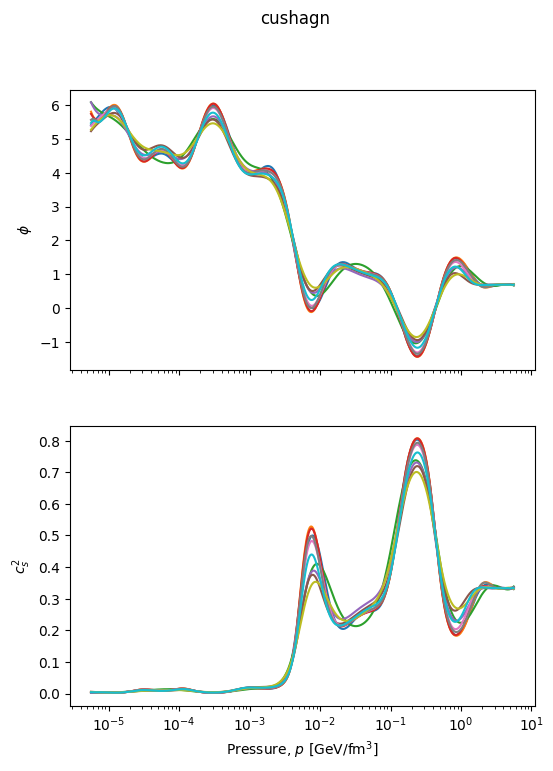

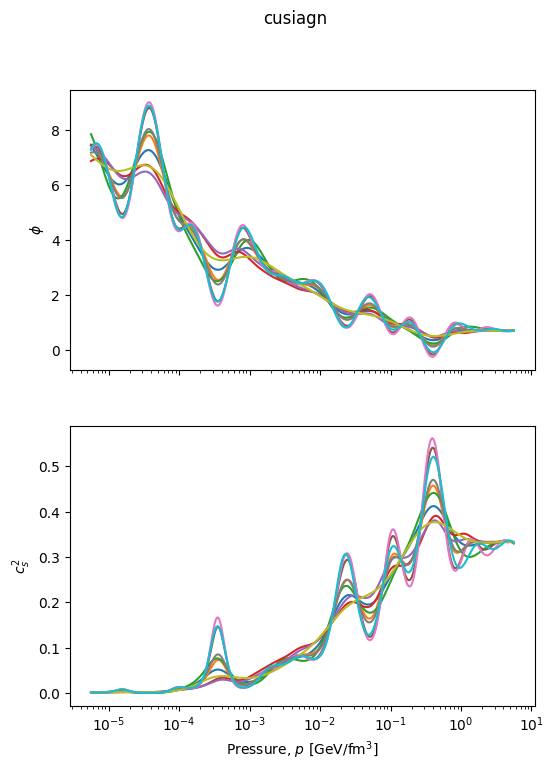

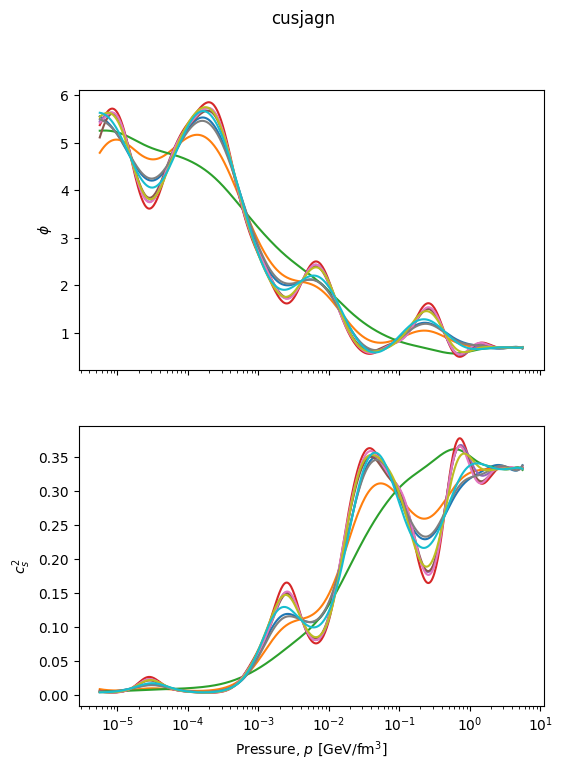

In [105]:
for label in new_mean_dict_verify.keys():

    fig, axs = plt.subplots(2, 1, sharex=True, figsize=(6,8))
    fig.suptitle(label)
    axs[0].set_xscale('log')

    for model_number in range(10):

        log_pressure, phi = new_mean_dict_verify[label][model_number]
        
        axs[0].plot(
            to_GeV_per_cubic_femtometre(np.exp(log_pressure)), 
            phi, 
        )
        axs[1].plot(
            to_GeV_per_cubic_femtometre(np.exp(log_pressure)), 
            1/(1+np.exp(phi)), 
        )

    axs[1].set_xlabel(r'Pressure, $p$ [GeV/fm$^3$]')
    axs[0].set_ylabel(r'$\phi$')
    axs[1].set_ylabel(r'$c_s^2$');

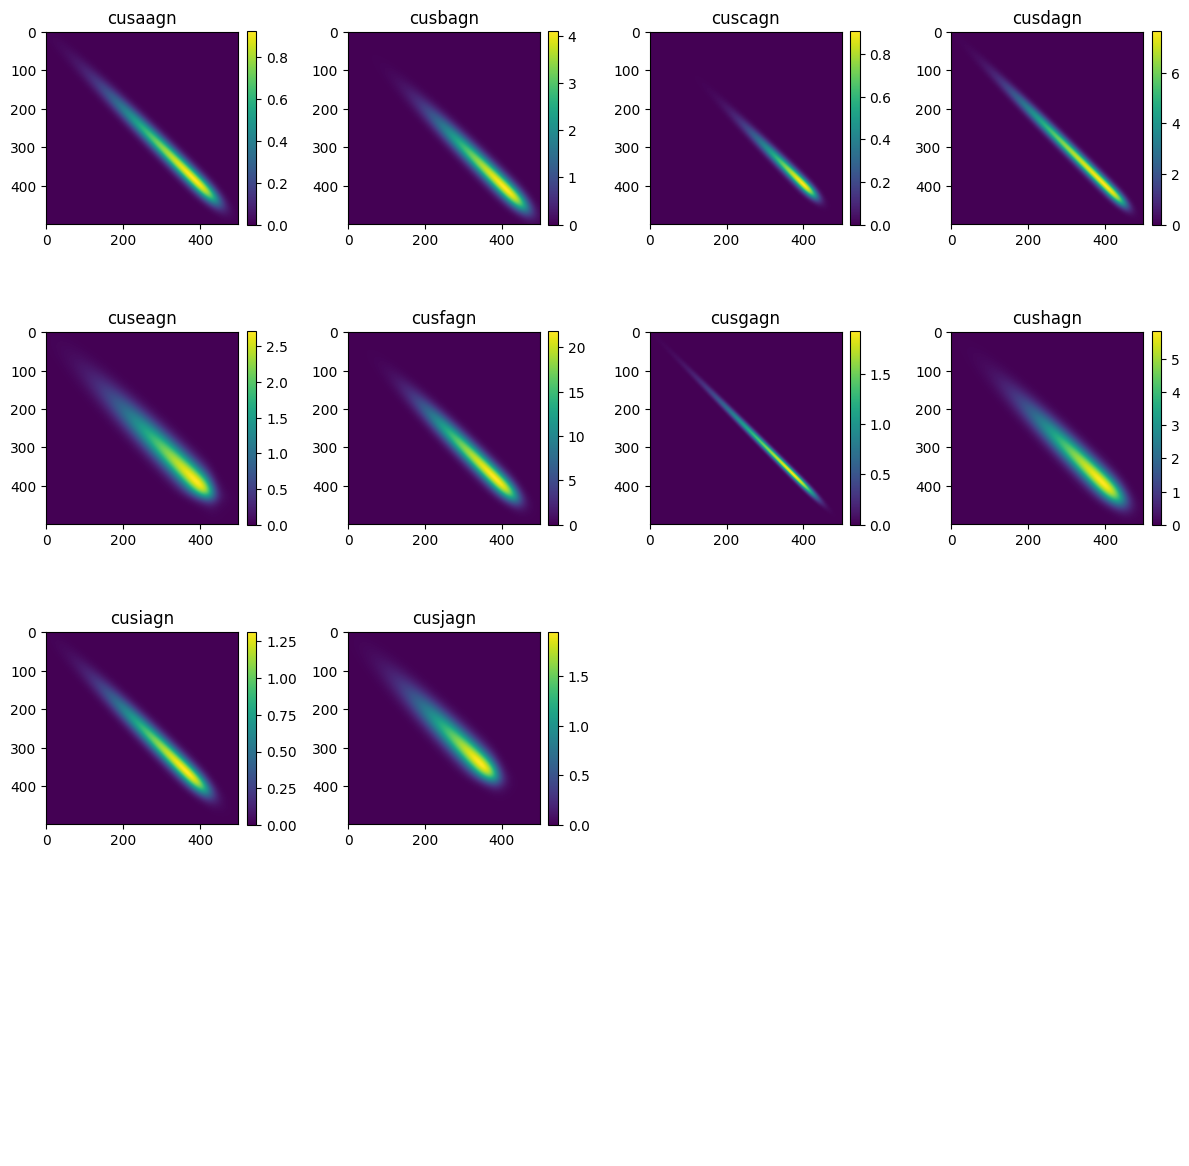

In [106]:
# Determine grid size
num_matrices = len(new_cov_dict_verify)
grid_size = int(np.ceil(np.sqrt(num_matrices)))  # Square grid

# Create subplots
fig, axs = plt.subplots(grid_size, grid_size, figsize=(12, 12))
axs = axs.flatten()  # Flatten the array of axes for easy iteration

# Loop through the dictionary and display each matrix
model_number = 0

for i, label in enumerate(new_cov_dict_verify.keys()):

    matrix = new_cov_dict_verify[label][model_number]

    im = axs[i].imshow(matrix, cmap='viridis')
    axs[i].set_title(label)
    fig.colorbar(im, ax=axs[i], fraction=0.046, pad=0.04)

# Hide any unused axes
for j in range(i + 1, len(axs)):
    axs[j].axis('off')

fig.tight_layout()

In [113]:
scaling_hyperparams = np.vstack([
    x_ref_low_sample, n_scale_low_sample, x_ref_high_sample, n_scale_high_sample, sigma_scale_high_sample
]).T

In [116]:
scaling_hyperparams_df = pd.DataFrame(
    scaling_hyperparams, 
    columns=['x_ref_low', 'n_scale_low', 'x_ref_high', 'n_scale_high', 'sigma_scale_high']
)

In [117]:
scaling_hyperparams_df

,x_ref_low,n_scale_low,x_ref_high,n_scale_high,sigma_scale_high
0,27.843170,13.159669,35.468999,-81.878449,0.003476
1,27.635120,16.577823,36.154896,-79.091404,0.011951
2,28.768774,14.926445,35.426430,-97.554619,0.000854
3,31.277501,16.031568,34.775447,-104.721926,0.015999
4,29.277540,14.269293,35.538567,-107.197179,0.009694
...,...,...,...,...,...
95,28.653079,13.300172,35.192505,-87.170871,0.007494
96,28.698324,18.338864,34.475866,-94.850429,0.012442
97,30.036606,13.608778,35.430712,-83.834763,0.015608
98,28.831590,16.968852,35.484405,-90.193289,0.000291


In [120]:
scaling_hyperparams_df.to_csv(dest_set / 'scaling_hyperparameters.csv', index=False)